In [1]:
import numpy as np
from scripts.mesh import Mesh
from scripts.topology_operations import *
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp

In [3]:
from scripts.grid import *
from scripts.segment import *

In [4]:
# class SegmentReport(object):
#     def __init__(self,grid_size):
#         self.grid_size = grid_size
#         self.num_sim = 0
#         self.segments = {}
#         self.segment_graph = None
    
#     def __str__(self):  
#         pipe_seg_ratio = self.num_pipe_segments/self.num_pipes
# #         print (self.pipe_seg_report)
#         return "pipes number:  %d, segment number: %d, pipe segment number %d, pipe_seg_ratio is %f" % (
#             self.num_pipes, self.num_segments,self.num_pipe_segments, pipe_seg_ratio)  

#     def get_segments_stats(self,trivial_pids = {}):
#         self.pipe_seg_report.update_stat(trivial_pids)
#         return self.pipe_seg_report.stat

In [5]:
# def generate_sim_report_topo(valve_register,valid_vids,num_simulation,fail_rate):
#     report = SegmentReport(grid_size)
#     for i in range(num_simulation):
#         valve_register.recover_valves()
#         vids2fail = generate_vids2fail(valid_vids,fail_rate) 
#         valves_dict = fail_valves(valve_register.vid2v,vids2fail)
#         segments = simulate_segments(grid_size,valves_dict)
#         report = update_segment_report(segments,report)
#     return report

# def generate_vids2fail(vids,fail_rate):
#     np.random.seed()
#     vids = list(vids)
#     num_failed_valves = int(fail_rate*len(vids))
#     rand_fvids = list(np.random.choice(vids, num_failed_valves, replace=False))
#     return rand_fvids


# def fail_valves(valves_dict, vids2fail):
#     for vid,v in valves_dict.items():
#         if vid in vids2fail:
#             v.fail = True
#     return valves_dict       

In [6]:
# # def get_trivial_pids(mesh):
# #     trivial_pids = mesh.closed_pids # always closed pipes 
# #     contraction_reg = mesh.contraction_reg
# #     trivial_pids.update(set(contraction_reg.trivial_pids)) # always open pipes 
    
# #     return trivial_pids
    
    
# def get_simulation_results(reports,trivial_pids = {}):
#     ave_num_segments = []
#     ave_seg_pipe_size = []
#     ave_max_pipe_seg = []
#     for report in reports:
#         stat = report.get_segments_stats(trivial_pids)
#         ave_num_segments.append(stat.num_multi_pipe_seg)
#         ave_seg_pipe_size.append(np.mean(stat.seg_sizes_mean))
#         ave_max_pipe_seg.append(np.mean(stat.seg_sizes_max))
#     return ave_num_segments,ave_seg_pipe_size,ave_max_pipe_seg

In [7]:
# def get_vids2open(mesh):
#     contraction_reg = mesh.contraction_reg
#     vids2open = []
#     for v1,v2 in contraction_reg.vpairs:
#         vids2open.append(v1.vid)
#         vids2open.append(v2.vid)
#     return vids2open


# def get_vids2close(mesh):
#     vids2close = []
#     for pid in mesh.closed_pids:
#         v1,v2 = valve_register.pid2v[pid]
#         vids2close.append(v1.vid)
#         vids2close.append(v2.vid)
#     return vids2close




In [8]:
# def simulate_segments(grid_size,valves_dict):
#     A = assemble_adjacency_mtx(grid_size,valves_dict)
#     segments = find_segments(A,grid_size*grid_size)
#     return segments

In [9]:
# from scripts.graph import *
# from scipy.sparse import lil_matrix

# class SegmentSummary(object):
#     def __init__(self,segments,A_diff,num_closed_pipes):
#         self.segments = segments
#         self.num_closed_pipes = num_closed_pipes
#         self.pipe_sids = self._get_pipe_seg_ids()
#         self.id2sid = self._get_id2sid()
        
#         self.segment_graph = self.convert2seg_graph(A_diff)
        
#     def _get_pipe_seg_ids(self):
#         sids = []
#         for seg in self.segments:
#             if len(seg.pids):
#                 sids.append(seg.sid)
#         return sids
    
#     def _get_id2sid(self):
#         id2sid ={}
#         for sid, seg in enumerate(self.segments):
#             for id in seg.ids:
#                 id2sid[id] = sid
#         return id2sid
    
#     def convert2seg_graph(self,A_diff):
#         segment_graph = lil_matrix((len(self.segments), len(self.segments)), 
#                                    dtype=np.int8)
#         for i in range(A_diff.shape[0]):
#             searching_sid = self.id2sid[i]
#             nearby_ids = np.nonzero(A_diff[i,:])[1]
#             for nearby_id in nearby_ids:
#                 nearby_sid = self.id2sid[nearby_id]
#                 segment_graph[searching_sid,nearby_sid] = 1  
#                 segment_graph[nearby_sid,searching_sid] = 1  
#         return segment_graph
    
    
#     def _get_unintend_consequence(self,segment_graph,iso_sids):
#         components = bfs(segment_graph)
#         unintend_consequence = 0
#         for iso_component in components[1:]:
#             for sid in iso_component:
#                 if sid not in iso_sids:
#                     seg = self.segments[sid]
#                     unintend_consequence += len(seg.pids)
# #         print (iso_sids,components[0],unintend_consequence,self.num_closed_pipes)
#         unintend_consequence -= self.num_closed_pipes
        
#         return unintend_consequence
        
#     def _iso_on_segment_graph(self,segment_graph,sid):
#         segment_graph[sid,:] = 0
#         segment_graph[:,sid] = 0
#         return segment_graph
    
#     def _iso_consequence(self,sids):
#         segment_graph = self.segment_graph.copy()
#         direct_consequence = 0
#         for sid in sids:
#             seg = self.segments[sid]
#             direct_consequence += len(seg.pids)
#             segment_graph = self._iso_on_segment_graph(segment_graph,sid)
#         unintend_consequence = self._get_unintend_consequence(segment_graph,sids)
#         return direct_consequence,unintend_consequence
        
    
#     def pipe_iso_consequences(self,num_nodes,pids):
#         direct_consequences = []
#         unintend_consequences = []
#         for pid in pids:
#             id = num_nodes + pid
#             sid = self.id2sid[id]
#             direct,unintened = self._iso_consequence([sid])
#             direct_consequences.append(direct)
#             unintend_consequences.append(unintened)
#         return np.array(direct_consequences),np.array(unintend_consequences)
            
                
#     def _multi_pipe_iso_consequence(self,num_nodes,pids2close):
#         sids = []
#         for pid in pids2close:
#             id = num_nodes + pid
#             sids.append(self.id2sid[id])
#         return self._iso_consequence(sids)
    
    
#     def multi_pipe_iso_consequences(self,num_nodes,valid_pids,degree,num_sim = 100):
#         pids2close_pool = [np.random.choice(list(valid_pids),degree,replace = False) for _ in range(num_sim)]
#         directs, unintends = [], []
#         for pids2close in pids2close_pool:
#             direct, unintend = self._multi_pipe_iso_consequence(num_nodes, pids2close)
#             directs.append(direct)
#             unintends.append(unintend)
            
#         return np.mean(directs),np.mean(unintends)
                
                
            
            
    
            
    
        

In [10]:
# def create_null_valves_dict(valves_dict,valid_vids):
#     null_dict = valves_dict.copy()
#     for vid,v in null_dict.items():
#         if vid in valid_vids:
#             v.fail = True
#     return null_dict       

# def create_mtx_diff(grid_size, valves_dict,valid_vids):
#     A = assemble_adjacency_mtx(grid_size,valves_dict)
#     null_valves = create_null_valves_dict(valves_dict,valid_vids)
#     A_null = assemble_adjacency_mtx(grid_size,null_valves)
#     A_diff = A_null - A
#     return A_diff
    

        
        
    
    

In [11]:
# class TestSegmentSummary(unittest.TestCase):
#     def setUp(self):
#         self.grid_size = 10
#         valves = generate_valves_grid(self.grid_size)
#         self.valve_register = ValveRegister()
#         register_valves(valves,self.valve_register)
    
#     def test_normal_condition(self):
#         fail_rate = 0.1
#         valid_vids = self.valve_register.vid2valves.keys()
#         vids2fail = generate_vids2fail(valid_vids,fail_rate) 
#         valves_dict = fail_valves(self.valve_register.vid2v,vids2fail)
#         segments = simulate_segments(grid_size,valves_dict)
        
#         mtx_diff = create_mtx_diff(self.grid_size, valves_dict)
#         seg_sum = SegmentSummary(segments,mtx_diff)
        
    

        

In [12]:
# def reduce_mesh_degree(mesh,degree_setting):
#     mesh.reduce_degree_num(6,int(len(mesh.degree_distribution[6])*degree_setting[6]))
#     mesh.reduce_degree_num(5,int(len(mesh.degree_distribution[5])*degree_setting[5]))
#     mesh.reduce_degree_num(4,int(len(mesh.degree_distribution[4])*degree_setting[4]))
#     mesh.reduce_degree_num(3,int(len(mesh.degree_distribution[3])*degree_setting[3]))
#     mesh.reduce_degree_num(2,int(len(mesh.degree_distribution[2])*degree_setting[2]))
#     return mesh

# def create_mesh(mesh_settings):
#     grid_size = mesh_settings['grid_size']
#     contraction_ratio = mesh_settings['contraction_ratio']
    
#     mesh = Mesh(grid_size)
#     nids2identify = get_nids2identify(grid_size,contraction_ratio)
#     identify_pairs_op =  get_identify_pairs_op(nids2identify,mesh.nid2nodes)
#     mesh.perform_contractions(identify_pairs_op)
    
#     mesh = reduce_mesh_degree(mesh,mesh_settings['degree_settings'])
    
#     return mesh
    
# def calculate_sparseness(mesh):
#     valid_pids = mesh.valid_pids
#     num_skeleton_pipes = len(mesh.bfs_edges)-len(mesh.get_open_pids())
#     num_grid_pipes = 2* (mesh.grid_size-1)*mesh.grid_size - len(mesh.get_open_pids())
#     sparseness = (len(valid_pids)-num_skeleton_pipes)/(num_grid_pipes-num_skeleton_pipes)
#     return sparseness
    

In [13]:
# def generate_seg_sum(mesh,vfail_rate):
#     valve_register = mesh.valve_register
#     valve_register.recover_valves()
#     vids2fail = generate_vids2fail(mesh.valid_vids,vfail_rate)
#     valves_dict = fail_valves(valve_register.vid2v,vids2fail)
#     segments = simulate_segments(mesh.grid_size,valves_dict)
#     mtx_diff = create_mtx_diff(mesh.grid_size,valves_dict,mesh.valid_vids)
#     num_closed_pipes = len(mesh.get_closed_pids())
#     seg_sum = SegmentSummary(segments,mtx_diff,num_closed_pipes)
#     return seg_sum
    

In [19]:
# def mc_degree_impact(mesh,fail_rate,degree,valid_pids,num_sim = 100):
#     directs,unintends = [],[]
    
#     for i in range (num_sim):
#         seg_sum = generate_seg_sum(mesh,fail_rate)
#         num_nodes = mesh.grid_size*mesh.grid_size
#         direct, unintend = seg_sum.multi_pipe_iso_consequences(num_nodes,valid_pids,degree)
#         directs.append(direct)
#         unintends.append(unintend)
        
#     return np.mean(directs),np.mean(unintends)
    

In [20]:
def parse_directs_unintends(result):
    directs, unintends = [], []
    for direct,unintend in result:
        directs.append(direct)
        unintends.append(unintend)
    return directs,unintends
        

In [21]:
mesh_degree_settings = {2:1,
                       3:1,
                       4:1,
                       5:1,
                       6:1}

mesh_settings = {'grid_size': 10,
                'contraction_ratio':0.,
                'degree_settings':mesh_degree_settings}


mesh = create_mesh(mesh_settings)
sparseness = calculate_sparseness(mesh)
print (sparseness)

1.0


In [22]:
# def valve_fail_simulation(fail_rates,mesh):
#     fail_results = []
#     for fail_rate in fail_rates:
#         print (f'Start simulating valve fail rate {fail_rate}')
#         pool = mp.Pool(15)
#         results = pool.starmap(mc_degree_impact, [(mesh,fail_rate,degree,mesh.valid_pids) for degree in range(1,15)])
#         pool.close()
#         fail_results.append(results)
#     return fail_results

In [23]:
fail_rates = np.linspace(0,0.5,5)
fail_results = valve_fail_simulation(fail_rates,mesh)

Start simulating valve fail rate 0.0
Start simulating valve fail rate 0.125
Start simulating valve fail rate 0.25
Start simulating valve fail rate 0.375
Start simulating valve fail rate 0.5


In [15]:
fail_rates = np.linspace(0,0.5,5)

fail_results = []
for fail_rate in fail_rates:
    print (fail_rate)
    pool = mp.Pool(15)
    results = pool.starmap(mc_degree_impact, [(mesh,fail_rate,degree,valid_pids) for degree in range(1,15)])
    pool.close()
    fail_results.append(results)
    
    

0.0
0.125
0.25
0.375
0.5


In [41]:
parsed_results = [parse_directs_unintends(result) for result in fail_results]

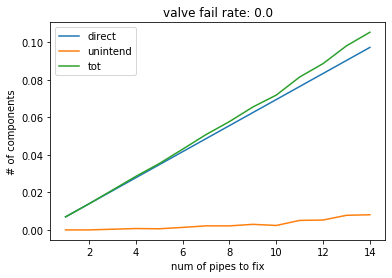

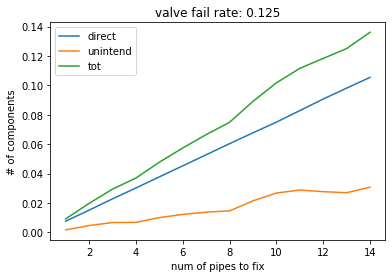

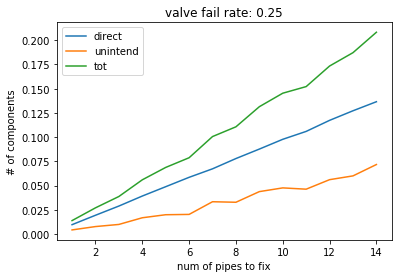

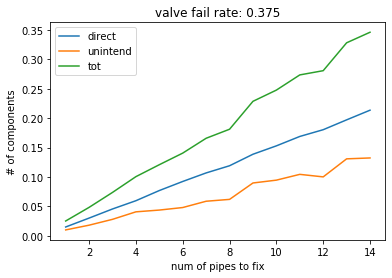

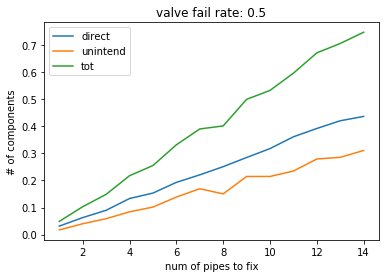

In [44]:
degrees = list(range(1,15))
for i,fail_rate in enumerate(fail_rates):
    direct, unintend = np.array(parsed_results[i][0]),np.array(parsed_results[i][1])
    tot = (direct+unintend) /144
    plt.plot(degrees, direct/144, label="direct")
    plt.plot(degrees, unintend/144, label="unintend")
    plt.plot(degrees, tot, label="tot")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('num of pipes to fix')
    plt.ylabel('# of components')
    plt.title(f'valve fail rate: {fail_rate}')
    # # plt.xlim(left = 0, right=0.5)
    #     plt.ylim(0,50)
    plt.legend()
    plt.show()

In [28]:
fail_rates = np.linspace(0,0.5,5)

fail_results_sparse = []
for fail_rate in fail_rates:
    print (fail_rate)
    pool = mp.Pool(15)
    results = pool.starmap(mc_degree_impact, [(mesh,fail_rate,degree,valid_pids) for degree in range(1,15)])
    pool.close()
    fail_results_sparse.append(results)
    
parsed_results = [parse_directs_unintends(result) for result in fail_results_sparse]  

0.0
0.125
0.25
0.375
0.5


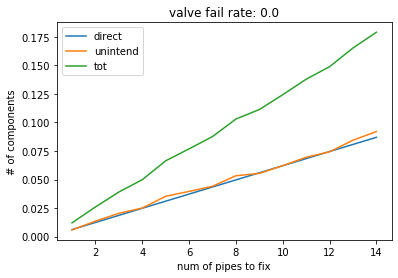

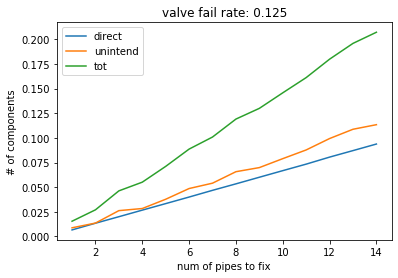

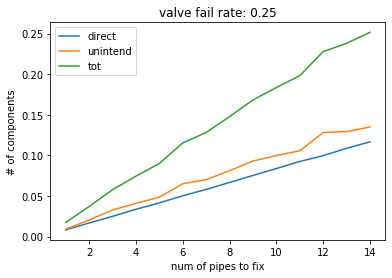

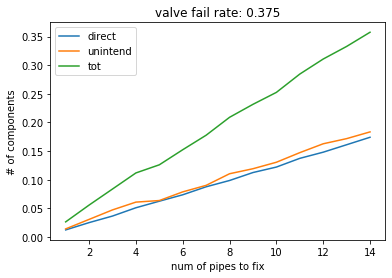

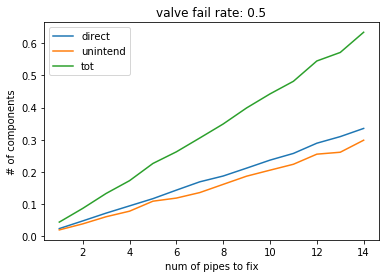

In [29]:
degrees = list(range(1,15))
for i, fail_rate in enumerate(fail_rates):
    direct, unintend = np.array(parsed_results[i][0]),np.array(parsed_results[i][1])
    tot = (direct+unintend) /len(valid_pids)
    plt.plot(degrees, direct/len(valid_pids), label="direct")
    plt.plot(degrees, unintend/len(valid_pids), label="unintend")
    plt.plot(degrees, tot, label="tot")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('num of pipes to fix')
    plt.ylabel('# of components')
    plt.title(f'valve fail rate: {fail_rate}')
    # # plt.xlim(left = 0, right=0.5)
    #     plt.ylim(0,50)
    plt.legend()
    plt.show()

In [30]:
fail_rates = np.linspace(0,0.5,5)

fail_results_sparse = []
for fail_rate in fail_rates:
    print (fail_rate)
    pool = mp.Pool(15)
    results = pool.starmap(mc_degree_impact, [(mesh,fail_rate,degree,valid_pids) for degree in range(1,15)])
    pool.close()
    fail_results_sparse.append(results)
    
    

0.0
0.125
0.25
0.375
0.5


In [45]:
parsed_results = [parse_directs_unintends(result) for result in fail_results_sparse]

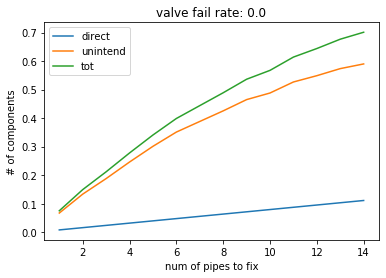

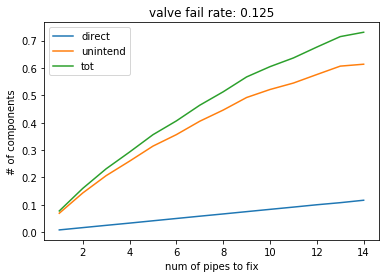

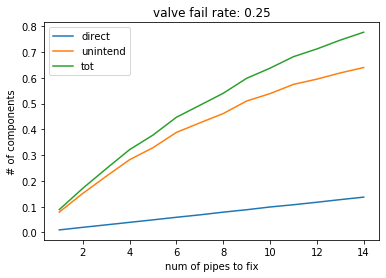

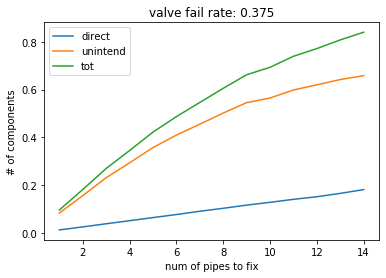

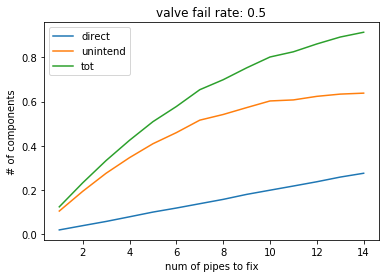

In [47]:
degrees = list(range(1,15))
for i, fail_rate in enumerate(fail_rates):
    direct, unintend = np.array(parsed_results[i][0]),np.array(parsed_results[i][1])
    tot = (direct+unintend) /len(valid_pids)
    plt.plot(degrees, direct/len(valid_pids), label="direct")
    plt.plot(degrees, unintend/len(valid_pids), label="unintend")
    plt.plot(degrees, tot, label="tot")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('num of pipes to fix')
    plt.ylabel('# of components')
    plt.title(f'valve fail rate: {fail_rate}')
    # # plt.xlim(left = 0, right=0.5)
    #     plt.ylim(0,50)
    plt.legend()
    plt.show()

In [18]:
fail_rates = np.linspace(0,0.5,5)

fail_results_sparse = []
for fail_rate in fail_rates:
    print (fail_rate)
    pool = mp.Pool(15)
    results = pool.starmap(mc_degree_impact, [(mesh,fail_rate,degree,valid_pids) for degree in range(1,15)])
    pool.close()
    fail_results_sparse.append(results)
    
    

0.0
0.125
0.25
0.375
0.5


In [19]:
parsed_results = [parse_directs_unintends(result) for result in fail_results_sparse]

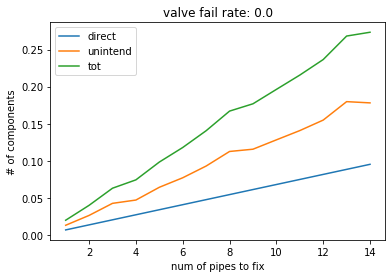

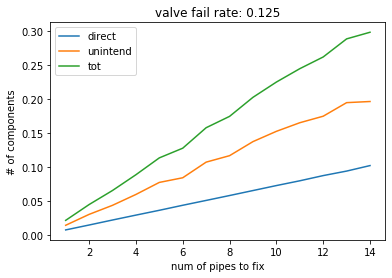

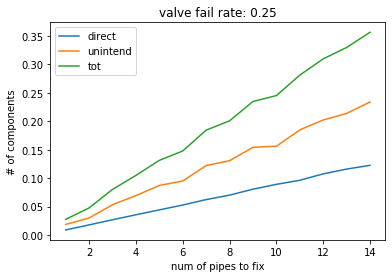

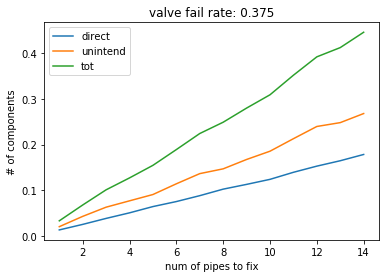

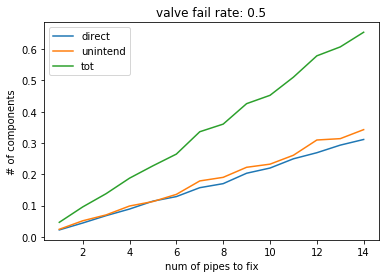

In [20]:
degrees = list(range(1,15))
for i, fail_rate in enumerate(fail_rates):
    direct, unintend = np.array(parsed_results[i][0]),np.array(parsed_results[i][1])
    tot = (direct+unintend) /len(valid_pids)
    plt.plot(degrees, direct/len(valid_pids), label="direct")
    plt.plot(degrees, unintend/len(valid_pids), label="unintend")
    plt.plot(degrees, tot, label="tot")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('num of pipes to fix')
    plt.ylabel('# of components')
    plt.title(f'valve fail rate: {fail_rate}')
    # # plt.xlim(left = 0, right=0.5)
    #     plt.ylim(0,50)
    plt.legend()
    plt.show()

In [23]:
fail_rates = np.linspace(0,0.5,5)

fail_results_sparse = []
for fail_rate in fail_rates:
    print (fail_rate)
    pool = mp.Pool(15)
    results = pool.starmap(mc_degree_impact, [(mesh,fail_rate,degree,valid_pids) for degree in range(1,15)])
    pool.close()
    fail_results_sparse.append(results)
    
parsed_results = [parse_directs_unintends(result) for result in fail_results_sparse]  

0.0
0.125
0.25
0.375
0.5


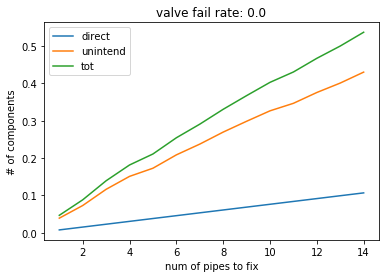

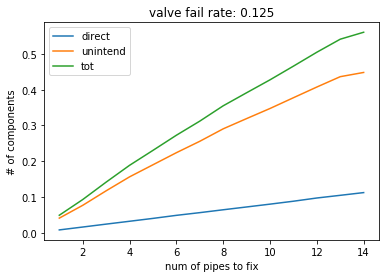

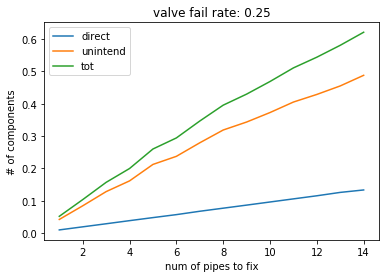

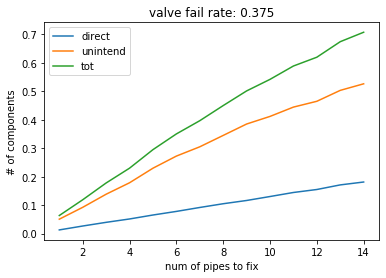

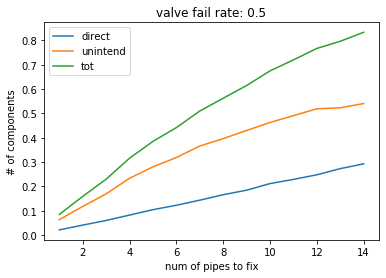

In [24]:
degrees = list(range(1,15))
for i, fail_rate in enumerate(fail_rates):
    direct, unintend = np.array(parsed_results[i][0]),np.array(parsed_results[i][1])
    tot = (direct+unintend) /len(valid_pids)
    plt.plot(degrees, direct/len(valid_pids), label="direct")
    plt.plot(degrees, unintend/len(valid_pids), label="unintend")
    plt.plot(degrees, tot, label="tot")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('num of pipes to fix')
    plt.ylabel('# of components')
    plt.title(f'valve fail rate: {fail_rate}')
    # # plt.xlim(left = 0, right=0.5)
    #     plt.ylim(0,50)
    plt.legend()
    plt.show()

In [320]:
fail_rates = np.linspace(0,0.5,10)
for fail_rate in fail_rates:
    print ("======================")
    print (f"FAIL RATE {fail_rate}")
    valve_register = mesh.valve_register
    valve_register.recover_valves()
    vids2fail = generate_vids2fail(mesh.valid_vids,fail_rate)
    valves_dict = fail_valves(valve_register.vid2v,vids2fail)
    segments = simulate_segments(mesh.grid_size,valves_dict)
    mtx_diff = create_mtx_diff(mesh.grid_size,valves_dict,mesh.valid_vids)
    num_closed_pipes = len(mesh.get_closed_pids())
    seg_sum = SegmentSummary(segments,mtx_diff,num_closed_pipes)

    num_samples = 500
    for pipes2repair in range(1,20):
        directs, unintends = [], []
        for _ in range(num_samples):
            pids2close = np.random.choice(list(valid_pids),pipes2repair,replace = False)
            direct, unintend = seg_sum.multi_pipe_iso_consequences(grid_size*grid_size,pids2close)
            directs.append(direct)
            unintends.append(unintend)

        print (pipes2repair,np.mean(directs),np.mean(unintends))

FAIL RATE 0.0


TypeError: multi_pipe_iso_consequences() missing 1 required positional argument: 'degree'

In [286]:
num_samples = 200
for pipes2repair in range(1,20):
    directs, unintends = [], []
    for _ in range(num_samples):
        pids2close = np.random.choice(list(valid_pids),pipes2repair,replace = False)
        direct, unintend = seg_sum.multi_pipe_iso_consequences(grid_size*grid_size,pids2close)
        directs.append(direct)
        unintends.append(unintend)

    print (pipes2repair,np.mean(directs),np.mean(unintends))

1 1.3 3.94
2 2.405 6.785
3 3.67 10.5
4 5.165 10.575
5 6.2 16.49
6 7.535 17.405
7 8.605 20.705
8 9.99 24.615
9 11.165 27.685
10 12.595 32.48
11 13.575 35.115
12 15.12 36.255
13 15.82 45.135
14 17.455 44.1
15 18.48 46.72
16 19.685 51.2
17 20.745 49.29
18 22.64 56.67
19 23.51 59.835


In [296]:
num_samples = 200
for pipes2repair in range(1,20):
    directs, unintends = [], []
    for _ in range(num_samples):
        pids2close = np.random.choice(list(valid_pids),pipes2repair)
        direct, unintend = seg_sum.multi_pipe_iso_consequences(grid_size*grid_size,pids2close)
        directs.append(direct)
        unintends.append(unintend)

    print (pipes2repair,np.mean(directs),np.mean(unintends))

1 1.185 0.03
2 2.45 4.405
3 3.63 7.265
4 4.75 9.46
5 5.96 15.425
6 7.29 17.03
7 8.365 17.09
8 9.46 15.265
9 10.915 20.55
10 11.945 18.31
11 13.385 19.42
12 14.33 18.005
13 15.605 26.32
14 17.165 20.265
15 17.865 24.025
16 19.28 31.195
17 20.4 36.905
18 21.65 37.72
19 22.975 29.645


In [300]:
num_samples = 200
for pipes2repair in range(1,20):
    directs, unintends = [], []
    for _ in range(num_samples):
        pids2close = np.random.choice(list(valid_pids),pipes2repair)
        direct, unintend = seg_sum.multi_pipe_iso_consequences(grid_size*grid_size,pids2close)
        directs.append(direct)
        unintends.append(unintend)

    print (pipes2repair,np.mean(directs),np.mean(unintends))

1 1.225 0.0
2 2.48 0.0
3 3.585 0.01
4 4.905 0.025
5 5.98 2.635
6 7.41 0.015
7 8.36 0.05
8 9.565 0.135
9 10.905 0.95
10 12.38 0.14
11 13.545 1.81
12 14.61 0.23
13 15.74 0.335
14 17.035 2.8
15 18.335 1.11
16 19.73 1.16
17 21.045 6.9
18 21.985 4.495
19 23.37 2.895


In [15]:
# for seg in seg_sum.segments:
#     print (seg)

In [16]:
# len(mesh.valid_pids)

In [17]:
def simulate_segmentation(mesh,fail_rate):
    valve_register = mesh.valve_register
    valve_register.recover_valves()
    vids2fail = generate_vids2fail(mesh.valid_vids,fail_rate)
    valves_dict = fail_valves(valve_register.vid2v,vids2fail)
    segments = simulate_segments(mesh.grid_size,valves_dict)
    mtx_diff = create_mtx_diff(mesh.grid_size,valves_dict,mesh.valid_vids)
    
    num_closed_pipes = len(mesh.get_closed_pids())
    seg_sum = SegmentSummary(segments,mtx_diff,num_closed_pipes)
    direct,unintend = seg_sum.pipe_iso_consequences(num_nodes,valid_pids)
    return (direct,unintend)

In [18]:
def get_average_result(results):
    tot_direct = np.zeros(len(valid_pids))
    tot_unintend = np.zeros(len(valid_pids))
    for direct,unintend in results:
        tot_direct+= direct
        tot_unintend += unintend
    num_sim = len(results)
    ave_direct = tot_direct/num_sim
    ave_unintend = tot_unintend/num_sim
    return ave_direct,ave_unintend

In [19]:
import multiprocessing as mp

def mc_segment_consequences(mesh,fail_rate,num_sim = 50):
    pool = mp.Pool(mp.cpu_count()-1)
    results = pool.starmap(simulate_segmentation, [(mesh, fail_rate) for i in range(num_sim)])
    pool.close()
    return get_average_result(results)
    

def get_consequences(mesh,fail_rates):
    directs, unintends = [], []
    for fail_rate in fail_rates:
        print (fail_rate)
        ave_direct,ave_unintend = mc_segment_consequences(mesh,fail_rate)
        directs.append(ave_direct)
        unintends.append(ave_unintend)
    return directs,unintends
    

In [20]:
def plot_trend(fail_rates,ave_direct,ave_unintend):
    tot = np.array(ave_direct)+np.array(ave_unintend)
    plt.plot(fail_rates, ave_direct, label="direct")
    plt.plot(fail_rates, ave_unintend, label="unintend")
    plt.plot(fail_rates, tot, label="tot")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('fail rate')
    plt.ylabel('# of components')
    # # plt.xlim(left = 0, right=0.5)
    #     plt.ylim(0,50)
    plt.legend()
    plt.show()

In [32]:
grid_size = 10
contraction_ratio = 0.
mesh = Mesh(grid_size)

nids2identify = get_nids2identify(grid_size,contraction_ratio)
identify_pairs_op =  get_identify_pairs_op(nids2identify,mesh.nid2nodes)
mesh.perform_contractions(identify_pairs_op)




mesh.reduce_degree_num(6,0)
mesh.reduce_degree_num(5,0)
mesh.reduce_degree_num(4,int(len(mesh.degree_distribution[4])*0.5))
mesh.reduce_degree_num(3,int(len(mesh.degree_distribution[3])*0.75))
mesh.reduce_degree_num(2,int(len(mesh.degree_distribution[2])*0.98))


valve_register = mesh.valve_register

num_nodes = grid_size*grid_size
valid_pids = mesh.valid_pids
print (len(valid_pids)/(len(mesh.bfs_edges)-len(mesh.get_open_pids())))

valid_vids = mesh.valid_vids
trivial_pids = list(mesh.get_open_pids()) +list(mesh.get_closed_pids())
print (len(valid_vids),len(valve_register.vid2v))



mesh.degree_distribution

1.4343434343434343
284 360


{0: [],
 1: [0, 1],
 2: [2,
  3,
  4,
  6,
  8,
  9,
  25,
  30,
  32,
  35,
  39,
  42,
  49,
  50,
  56,
  59,
  60,
  61,
  66,
  69,
  70,
  71,
  78,
  79,
  82,
  88,
  89,
  90,
  92,
  94,
  96,
  97,
  98,
  99],
 3: [5,
  7,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  18,
  19,
  20,
  22,
  28,
  29,
  31,
  34,
  38,
  40,
  43,
  44,
  45,
  46,
  48,
  51,
  52,
  53,
  55,
  58,
  64,
  65,
  68,
  72,
  74,
  76,
  80,
  84,
  86,
  87,
  91,
  93,
  95],
 4: [17,
  21,
  23,
  24,
  26,
  27,
  33,
  36,
  37,
  41,
  47,
  54,
  57,
  62,
  63,
  67,
  73,
  75,
  77,
  81,
  83,
  85],
 5: [],
 6: [],
 7: [],
 8: [],
 9: []}

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


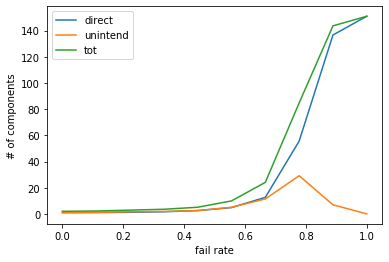

In [29]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

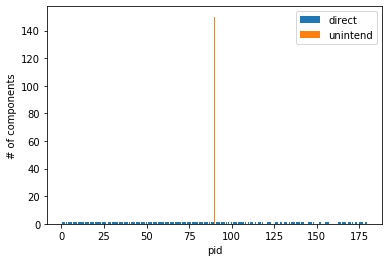

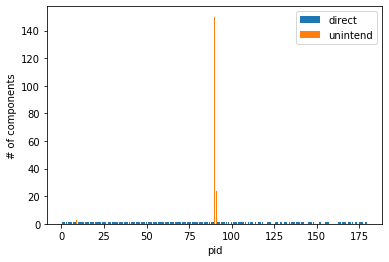

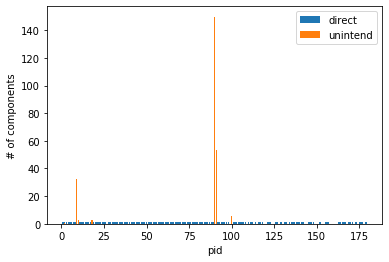

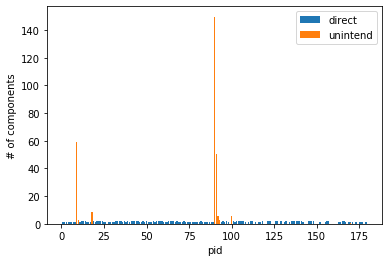

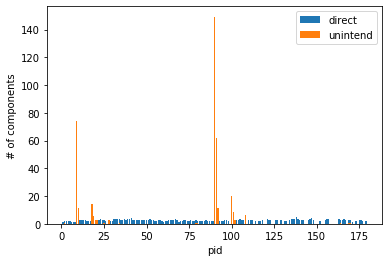

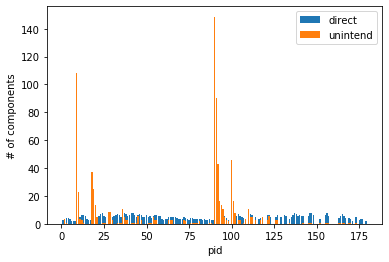

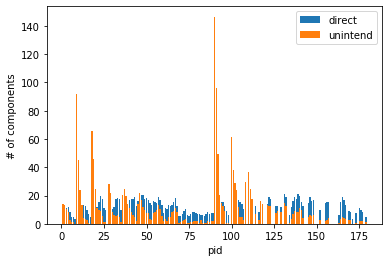

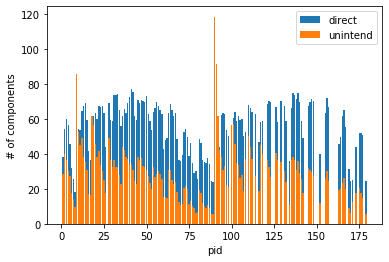

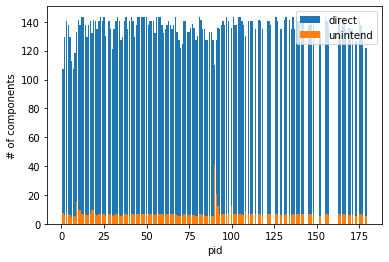

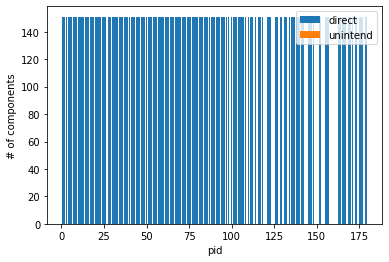

In [30]:
for direct, unintend in zip(directs, unintends):
    plt.bar(list(valid_pids), direct, label="direct")
    plt.bar(list(valid_pids), unintend, label="unintend")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('pid')
    plt.ylabel('# of components')
    # # plt.xlim(left = 0, right=0.5)
#     plt.ylim(0,50)
    plt.legend()
    plt.show()

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


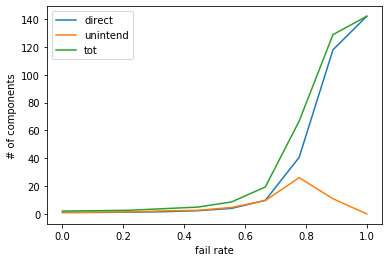

In [33]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

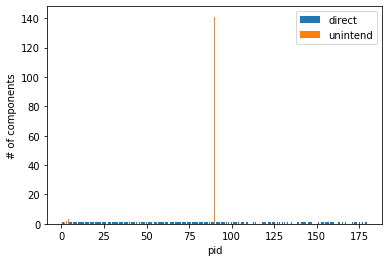

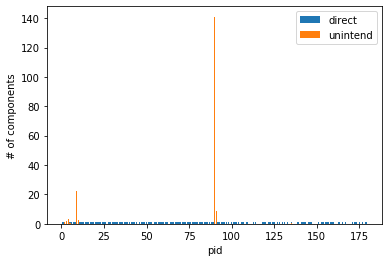

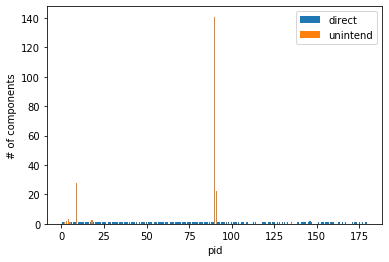

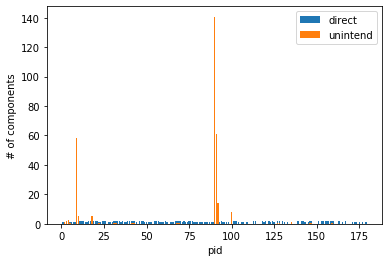

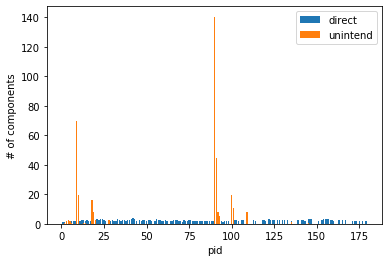

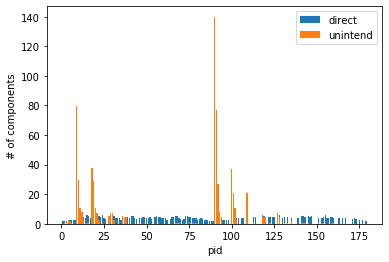

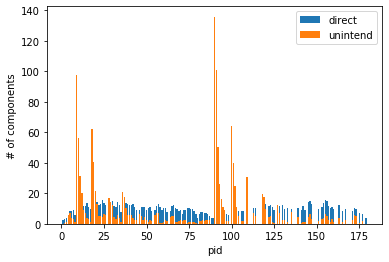

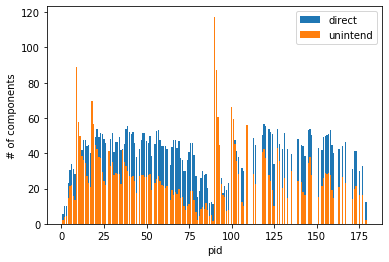

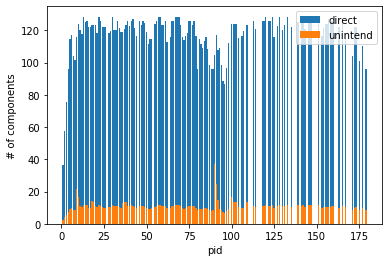

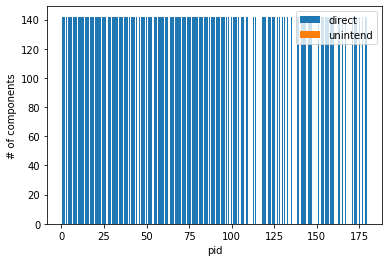

In [34]:
for direct, unintend in zip(directs, unintends):
    plt.bar(list(valid_pids), direct, label="direct")
    plt.bar(list(valid_pids), unintend, label="unintend")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('pid')
    plt.ylabel('# of components')
    # # plt.xlim(left = 0, right=0.5)
#     plt.ylim(0,50)
    plt.legend()
    plt.show()

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


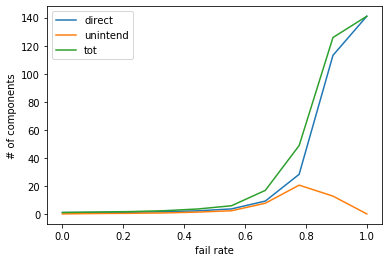

In [31]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


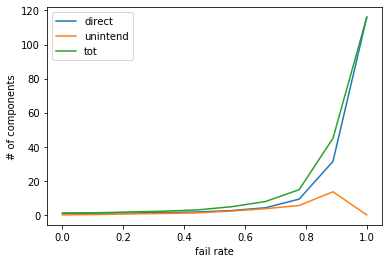

In [33]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


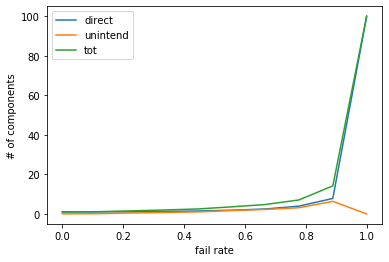

In [36]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


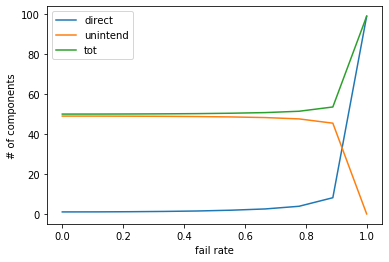

In [39]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


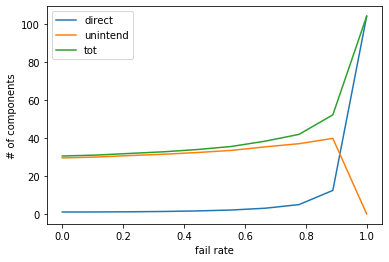

In [51]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


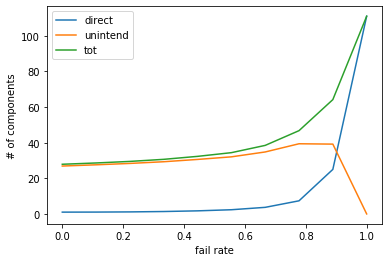

In [66]:
fail_rates = np.linspace(0.,1,10)
directs, unintends = get_consequences(mesh,fail_rates)
ave_direct = [np.mean(d) for d in directs]
ave_unintend = [np.mean(u) for u in unintends]
plot_trend(fail_rates,ave_direct,ave_unintend)

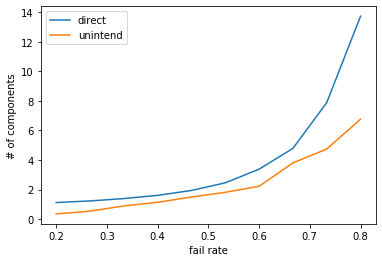

In [67]:
plt.plot(fail_rates, ave_direct, label="direct")
plt.plot(fail_rates, ave_unintend, label="unintend")
# plt.bar(ids, tot[num_nodes:], label="tot")

# # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('fail rate')
plt.ylabel('# of components')
# # plt.xlim(left = 0, right=0.5)
#     plt.ylim(0,50)
plt.legend()
plt.show()

In [46]:
grid_size = 10
contraction_ratio = 0.
mesh = Mesh(grid_size)

nids2identify = get_nids2identify(grid_size,contraction_ratio)
identify_pairs_op =  get_identify_pairs_op(nids2identify,mesh.nid2nodes)
mesh.perform_contractions(identify_pairs_op)




mesh.reduce_degree_num(6,0)
mesh.reduce_degree_num(5,0)
mesh.reduce_degree_num(4,0)
mesh.reduce_degree_num(3,0)
mesh.reduce_degree_num(3,0)
mesh.reduce_degree_num(2,100)

valve_register = mesh.valve_register

num_nodes = grid_size*grid_size
valid_pids = mesh.valid_pids
print (len(valid_pids)/(len(mesh.bfs_edges)-len(mesh.get_open_pids())))

valid_vids = mesh.valid_vids
trivial_pids = list(mesh.get_open_pids()) +list(mesh.get_closed_pids())
print (len(valid_vids),len(valve_register.vid2v))



# mesh.degree_distribution

1.0
198 360


In [47]:
fail_rates = np.linspace(0.2,0.8,10)
directs_tree, unintends_tree = [], []
for fail_rate in fail_rates:
    print (fail_rate)
    ave_direct,ave_unintend = mc_segment_consequences(mesh,fail_rate)
    directs_tree.append(ave_direct)
    unintends_tree.append(ave_unintend)
    

0.2
0.2666666666666667
0.33333333333333337
0.4
0.46666666666666673
0.5333333333333334
0.6000000000000001
0.6666666666666667
0.7333333333333334
0.8


In [71]:
import matplotlib
import matplotlib.pyplot as plt

ave_direct = []
ave_unintend = []
for direct, unintend in zip(directs_tree, unintends_tree):
# plt.plot(fail_rates, topo_report5[2], label="dense (cr = 0.4)", linewidth=2)
#     plt.bar(list(valid_pids), direct, label="direct")
#     plt.bar(list(valid_pids), unintend, label="unintend")
#     # plt.bar(ids, tot[num_nodes:], label="tot")

#     # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
#     plt.xlabel('pid')
#     plt.ylabel('# of components')
#     # # plt.xlim(left = 0, right=0.5)
# #     plt.ylim(0,50)
#     plt.legend()
#     plt.show()
    
    ave_direct.append(np.mean(direct))
    ave_unintend.append(np.mean(unintend))

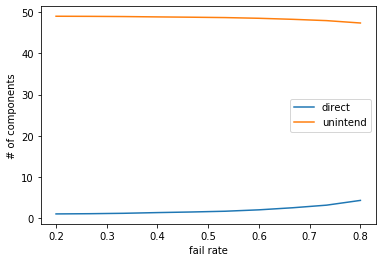

In [72]:
plt.plot(fail_rates, ave_direct, label="direct")
plt.plot(fail_rates, ave_unintend, label="unintend")
# plt.bar(ids, tot[num_nodes:], label="tot")

# # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('fail rate')
plt.ylabel('# of components')
# # plt.xlim(left = 0, right=0.5)
#     plt.ylim(0,50)
plt.legend()
plt.show()

In [74]:
grid_size = 10
contraction_ratio = 0.
mesh = Mesh(grid_size)

nids2identify = get_nids2identify(grid_size,contraction_ratio)
identify_pairs_op =  get_identify_pairs_op(nids2identify,mesh.nid2nodes)
mesh.perform_contractions(identify_pairs_op)




mesh.reduce_degree_num(6,0)
mesh.reduce_degree_num(5,0)
mesh.reduce_degree_num(4,5)
mesh.reduce_degree_num(3,15)


valve_register = mesh.valve_register

num_nodes = grid_size*grid_size
valid_pids = mesh.valid_pids
print (len(valid_pids)/(len(mesh.bfs_edges)-len(mesh.get_open_pids())))

valid_vids = mesh.valid_vids
trivial_pids = list(mesh.get_open_pids()) +list(mesh.get_closed_pids())
print (len(valid_vids),len(valve_register.vid2v))



# mesh.degree_distribution

1.0909090909090908
216 360


In [75]:
fail_rates = np.linspace(0.2,0.8,10)
directs_sparse2, unintends_sparse2 = [], []
for fail_rate in fail_rates:
    print (fail_rate)
    ave_direct,ave_unintend = mc_segment_consequences(mesh,fail_rate)
    directs_sparse2.append(ave_direct)
    unintends_sparse2.append(ave_unintend)
    

0.2
0.2666666666666667
0.33333333333333337
0.4
0.46666666666666673
0.5333333333333334
0.6000000000000001
0.6666666666666667
0.7333333333333334
0.8


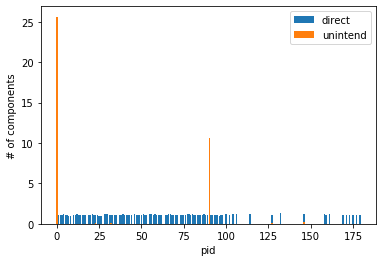

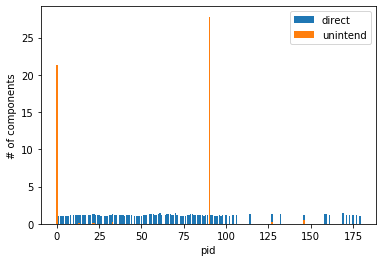

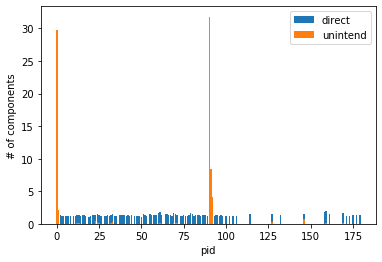

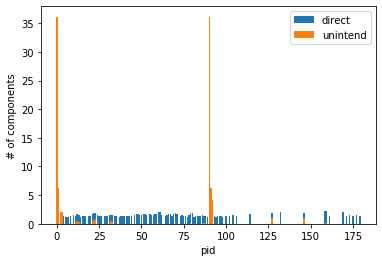

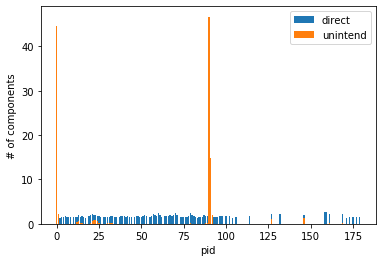

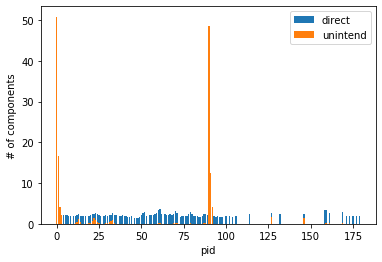

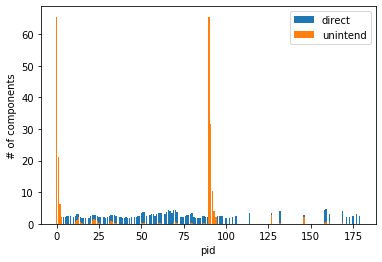

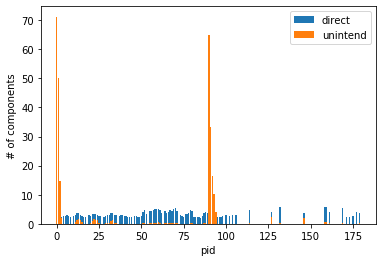

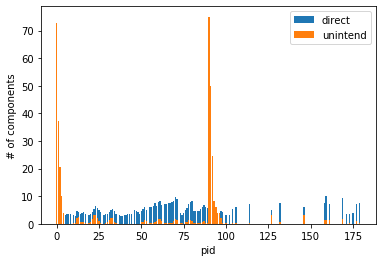

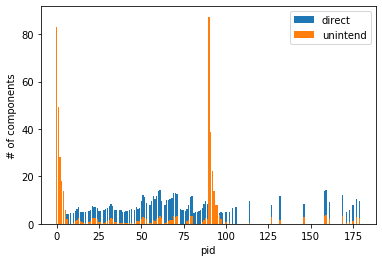

In [80]:
import matplotlib
import matplotlib.pyplot as plt

ave_direct = []
ave_unintend = []
for direct, unintend in zip(directs_sparse2, unintends_sparse2):
    plt.bar(list(valid_pids), direct, label="direct")
    plt.bar(list(valid_pids), unintend, label="unintend")
    # plt.bar(ids, tot[num_nodes:], label="tot")

    # # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
    plt.xlabel('pid')
    plt.ylabel('# of components')
    # # plt.xlim(left = 0, right=0.5)
#     plt.ylim(0,50)
    plt.legend()
    plt.show()
    
    ave_direct.append(np.mean(direct))
    ave_unintend.append(np.mean(unintend))

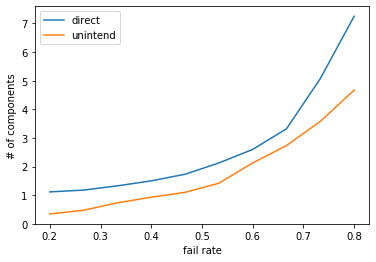

In [81]:
plt.plot(fail_rates, ave_direct, label="direct")
plt.plot(fail_rates, ave_unintend, label="unintend")
# plt.bar(ids, tot[num_nodes:], label="tot")

# # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('fail rate')
plt.ylabel('# of components')
# # plt.xlim(left = 0, right=0.5)
#     plt.ylim(0,50)
plt.legend()
plt.show()

In [107]:
sim_report_topo = partial(generate_sim_report_topo,valve_register,valid_vids,
                          num_simulation)
reports = pool.map(sim_report_topo,fail_rates)



In [53]:
topo_report0 = get_simulation_results(reports,trivial_pids)

In [60]:
topo_report1 = get_simulation_results(reports,trivial_pids)

In [68]:
topo_report2 = get_simulation_results(reports,trivial_pids)

In [77]:
topo_report3 = get_simulation_results(reports,trivial_pids)

In [89]:
topo_report4 = get_simulation_results(reports,trivial_pids)

In [108]:
topo_report5 = get_simulation_results(reports,trivial_pids)

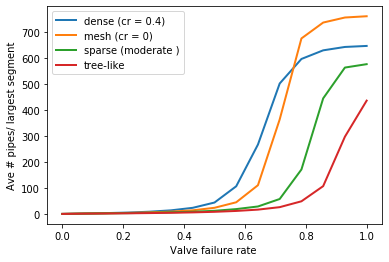

In [110]:
import matplotlib
import matplotlib.pyplot as plt

# plt.plot(fail_rates, topo_report5[2], label="dense (cr = 0.4)", linewidth=2)
plt.plot(fail_rates, topo_report0[2], label="dense (cr = 0.4)", linewidth=2)
plt.plot(fail_rates, topo_report1[2], label="mesh (cr = 0)", linewidth=2)
plt.plot(fail_rates, topo_report2[2], label="sparse (moderate )", linewidth=2)
plt.plot(fail_rates, topo_report3[2], label="tree-like", linewidth=2)
# plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('Ave # pipes/ largest segment')
# plt.xlim(left = 0, right=0.5)
# plt.ylim(0,50)
plt.legend()
plt.show()

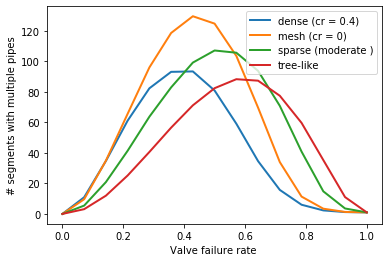

In [111]:
plt.plot(fail_rates, topo_report0[0], label="dense (cr = 0.4)", linewidth=2)
plt.plot(fail_rates, topo_report1[0], label="mesh (cr = 0)", linewidth=2)
plt.plot(fail_rates, topo_report2[0], label="sparse (moderate )", linewidth=2)
plt.plot(fail_rates, topo_report3[0], label="tree-like", linewidth=2)
# plt.plot(fail_rates, topo_report4[0], label="tree-like", linewidth=2)
plt.xlabel('Valve failure rate ')
plt.ylabel('# segments with multiple pipes')
plt.legend()
# plt.savefig('./results/num_notrivial_segs.png',dpi=300, bbox_inches='tight')

In [59]:
topo_report3

([0.0,
  1.77,
  7.04,
  14.55,
  23.11,
  32.04,
  40.2,
  47.08,
  49.89,
  48.8,
  43.43,
  33.72,
  19.23,
  6.19,
  1.0],
 [1.0,
  1.0075208990487474,
  1.0320895613170462,
  1.0727880461118073,
  1.1334847726842898,
  1.2178797023163983,
  1.3398436512514784,
  1.5188837191031306,
  1.7770845495050183,
  2.171025402453309,
  2.848497693549553,
  4.242832953723447,
  8.02486087255166,
  27.775231190378253,
  246.0],
 [1.0,
  1.95,
  2.47,
  3.18,
  4.11,
  5.14,
  6.42,
  8.33,
  11.2,
  16.56,
  25.8,
  44.83,
  93.48,
  196.03,
  246.0])